# IMDB project

In [1]:
import pandas as pd
import re
import string
import nltk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/homemac/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/homemac/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### **1️⃣ Load and Preprocess Data**

In [2]:
df = pd.read_csv('IMDB Dataset.csv')
df_subset = df.sample(50000, random_state=42)


# Load stop words
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

# Preprocessing function
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'<.*?>', '', text)  # Remove HTML
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    words = text.split()
    words = [word for word in words if word not in stop_words]  # Remove stopwords
    words = [stemmer.stem(word) for word in words]  # Apply stemming
    return " ".join(words)

# Apply preprocessing
tqdm.pandas(desc="Processing Reviews")
df_subset['cleaned_text'] = df_subset['review'].progress_apply(clean_text)

df_subset.to_csv("cleaned_subset.csv", index=False)

Processing Reviews: 100%|██████████| 50000/50000 [01:16<00:00, 652.89it/s]


### **2️⃣ Define Experiment Parameters**

In [3]:
sample_sizes = [500, 5000]
vectorizer_types = ["binary", "count"]
feature_counts = [5000, 10000]
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "SVM": SVC()
}

results = []

In [4]:
from sklearn.model_selection import GridSearchCV

param_grids = {
    "Logistic Regression": {
        "max_iter": [500, 1000]
    },
    "Random Forest": {
        "n_estimators": [50, 100, 200],  # Number of trees
    },
    "SVM": {
        "C": [0.1, 1, 10],  # Regularization strength
    }
}


### **3️⃣ Experiment Function**

In [5]:
def run_experiment(sample_size, vectorizer_type, max_features, model_name, base_model, param_grid):
    df_sample = df_subset.sample(sample_size, random_state=42)

    # Split data
    train, test = train_test_split(df_sample, test_size=0.1, stratify=df_sample['sentiment'], random_state=42)
    train, val = train_test_split(train, test_size=0.2, stratify=train['sentiment'], random_state=42)

    # Choose feature engineering method
    if vectorizer_type == "binary":
        vectorizer = CountVectorizer(binary=True, max_features=max_features, ngram_range=(1,2))
    else:  # "count"
        vectorizer = CountVectorizer(max_features=max_features, ngram_range=(1,2))

    # Transform text data
    X_train = vectorizer.fit_transform(train['cleaned_text'])
    X_val = vectorizer.transform(val['cleaned_text'])
    X_test = vectorizer.transform(test['cleaned_text'])

    y_train = train['sentiment']
    y_val = val['sentiment']
    y_test = test['sentiment']

    # Perform hyperparameter tuning with GridSearchCV
    grid_search = GridSearchCV(base_model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Best model after hyperparameter tuning
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Evaluate on validation set
    y_val_pred = best_model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)

    # Evaluate on test set only if validation accuracy is good
    if val_accuracy > 0.75:  # Example threshold
        y_test_pred = best_model.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_test_pred)
    else:
        test_accuracy = None  # Skip models with low validation accuracy

    # Store results
    results.append({
        "Sample Size": sample_size,
        "Vectorizer": vectorizer_type,
        "Features": max_features,
        "Model": model_name,
        "Best Params": best_params,
        "Validation Accuracy": val_accuracy,
        "Test Accuracy": test_accuracy
    })

    return best_params, val_accuracy, test_accuracy


### **4️⃣ Run Experiments**

In [6]:
for sample in sample_sizes:
    for vec in vectorizer_types:
        for features in feature_counts:
            for model_name, base_model in models.items():
                param_grid = param_grids.get(model_name, {})  # Get hyperparameter grid
                best_params, val_acc, test_acc = run_experiment(sample, vec, features, model_name, base_model, param_grid)
                
                print(f"Sample Sizes: {sample}, vectorizer Types: {vec}, Features Counts: {features}")
                print(f"Model: {model_name}, Best Params: {best_params}, Val Acc: {val_acc:.2f}, Test Acc: {test_acc if test_acc else 'Skipped'}", '\n')

results_df = pd.DataFrame(results)

# Find the best model based on validation accuracy
best_model_row = results_df.loc[results_df['Validation Accuracy'].idxmax()]
print("Best Model Based on Validation Set:")
print(best_model_row)

# Save experiment results
results_df.to_csv("hyperparameter_tuned_results.csv", index=False)


Sample Sizes: 500, vectorizer Types: binary, Features Counts: 5000
Model: Logistic Regression, Best Params: {'max_iter': 500}, Val Acc: 0.78, Test Acc: 0.8 

Sample Sizes: 500, vectorizer Types: binary, Features Counts: 5000
Model: Random Forest, Best Params: {'n_estimators': 50}, Val Acc: 0.76, Test Acc: 0.76 

Sample Sizes: 500, vectorizer Types: binary, Features Counts: 5000
Model: SVM, Best Params: {'C': 10}, Val Acc: 0.81, Test Acc: 0.76 

Sample Sizes: 500, vectorizer Types: binary, Features Counts: 10000
Model: Logistic Regression, Best Params: {'max_iter': 500}, Val Acc: 0.79, Test Acc: 0.8 

Sample Sizes: 500, vectorizer Types: binary, Features Counts: 10000
Model: Random Forest, Best Params: {'n_estimators': 200}, Val Acc: 0.77, Test Acc: 0.74 

Sample Sizes: 500, vectorizer Types: binary, Features Counts: 10000
Model: SVM, Best Params: {'C': 10}, Val Acc: 0.81, Test Acc: 0.78 

Sample Sizes: 500, vectorizer Types: count, Features Counts: 5000
Model: Logistic Regression, Best

### **5️⃣ Visualize Experiment Results**

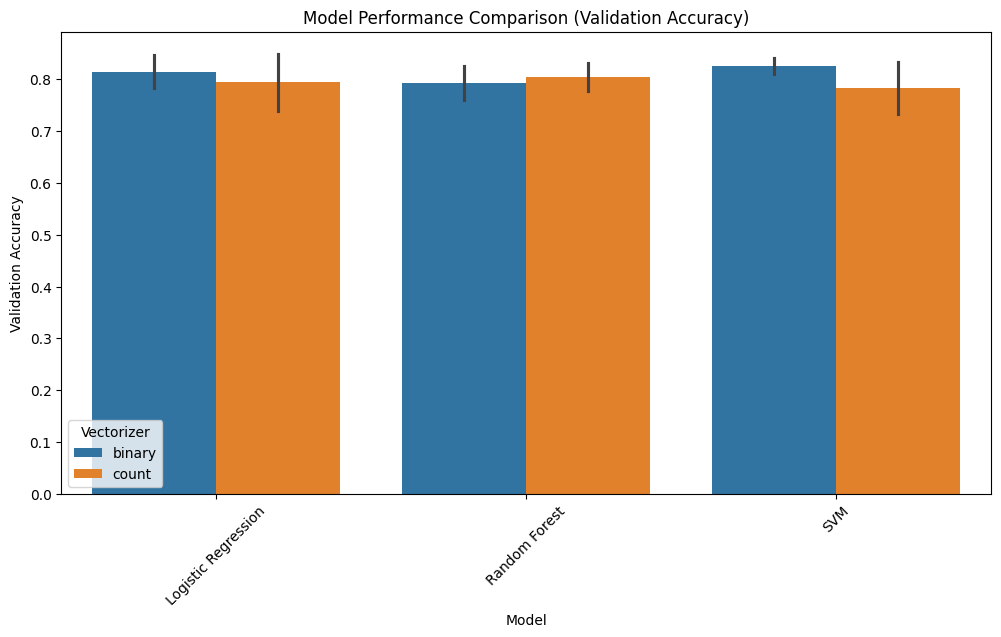

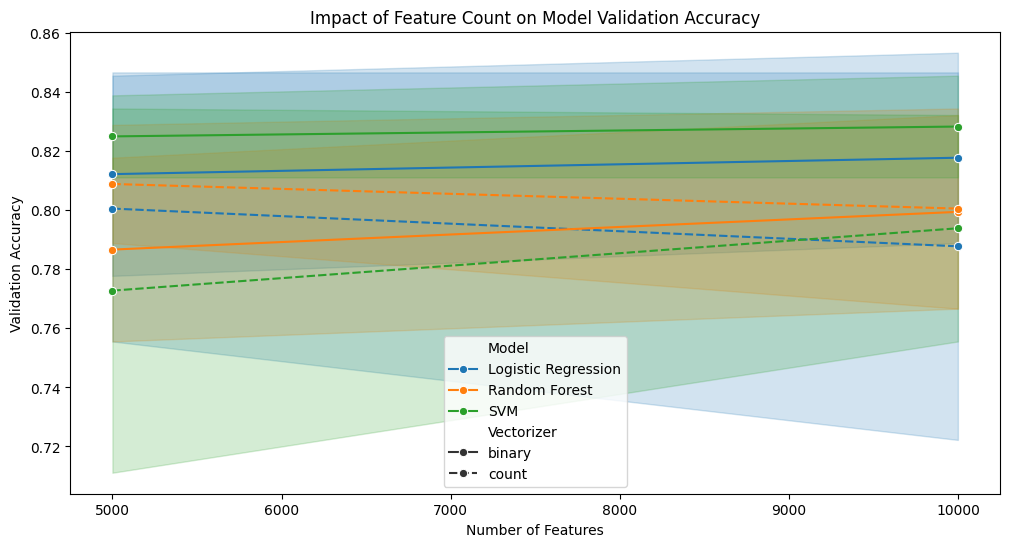

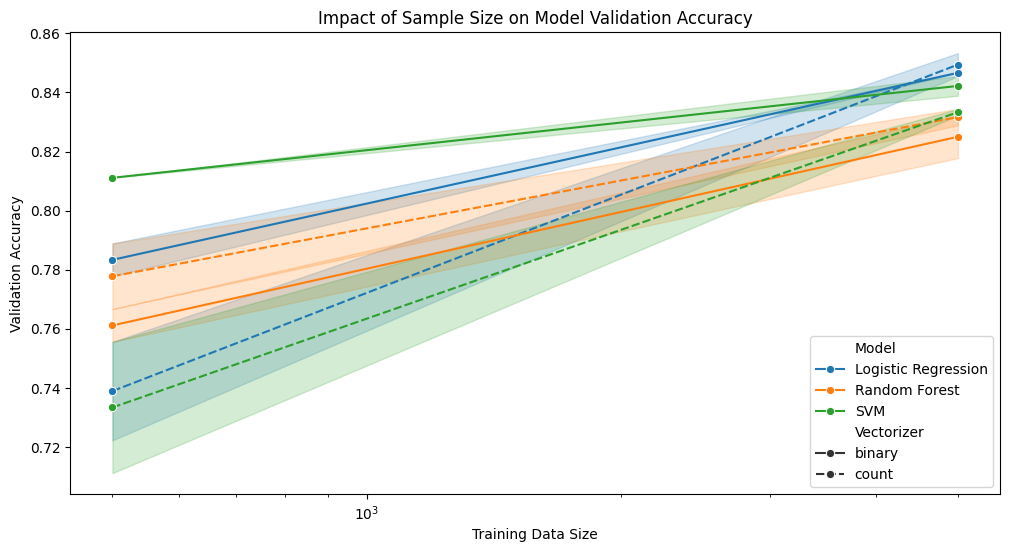

Experiment Results:


,Sample Size,Vectorizer,Features,Model,Best Params,Validation Accuracy,Test Accuracy
0,500,binary,5000,Logistic Regression,{'max_iter': 500},0.777778,0.80
1,500,binary,5000,Random Forest,{'n_estimators': 50},0.755556,0.76
2,500,binary,5000,SVM,{'C': 10},0.811111,0.76
3,500,binary,10000,Logistic Regression,{'max_iter': 500},0.788889,0.80
4,500,binary,10000,Random Forest,{'n_estimators': 200},0.766667,0.74


In [ ]:
# Compare Accuracy Across Models
plt.figure(figsize=(12,6))
sns.barplot(data=results_df, x="Model", y="Validation Accuracy", hue="Vectorizer")
plt.title("Model Performance Comparison (Validation Accuracy)")
plt.xticks(rotation=45)
plt.show()


# Compare Accuracy Across Feature Counts
plt.figure(figsize=(12,6))
sns.lineplot(data=results_df, x="Features", y="Validation Accuracy", hue="Model", style="Vectorizer", marker="o")
plt.title("Impact of Feature Count on Model Validation Accuracy")
plt.xlabel("Number of Features")
plt.ylabel("Validation Accuracy")
plt.show()


# Compare Accuracy for Different Data Sample Sizes
plt.figure(figsize=(12,6))
sns.lineplot(data=results_df, x="Sample Size", y="Validation Accuracy", hue="Model", style="Vectorizer", marker="o")
plt.title("Impact of Sample Size on Model Validation Accuracy")
plt.xlabel("Training Data Size")
plt.ylabel("Validation Accuracy")
plt.xscale("log")  # Log scale for better visibility
plt.show()


print("Experiment Results:")
results_df.head()

### **6️⃣ Train the Best Model on Full Data**

In [8]:
# Train the best model on the full training data
best_model_name = best_model_row["Model"]
best_vectorizer_type = best_model_row["Vectorizer"]
best_features = best_model_row["Features"]
best_params = best_model_row["Best Params"]

print(f"Retraining the best model: {best_model_name} with params {best_params}")

# Load full dataset
full_train, full_test = train_test_split(df_subset, test_size=0.1, stratify=df_subset['sentiment'], random_state=42)

if best_vectorizer_type == "binary":
    final_vectorizer = CountVectorizer(binary=True, max_features=best_features, ngram_range=(1,2))
else:
    final_vectorizer = CountVectorizer(max_features=best_features, ngram_range=(1,2))

X_full_train = final_vectorizer.fit_transform(full_train['cleaned_text'])
X_full_test = final_vectorizer.transform(full_test['cleaned_text'])

y_full_train = full_train['sentiment']
y_full_test = full_test['sentiment']

# Get the model with the best hyperparameters
final_model = models[best_model_name].set_params(**best_params)
final_model.fit(X_full_train, y_full_train)

# Evaluate on the test set
final_y_test_pred = final_model.predict(X_full_test)
final_test_accuracy = accuracy_score(y_full_test, final_y_test_pred)

print(f"Final Test Accuracy of {best_model_name}: {final_test_accuracy:.2f}")


Retraining the best model: Logistic Regression with params {'max_iter': 500}
Final Test Accuracy of Logistic Regression: 0.88
